# XGBoost

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import reduce_memory_usage
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import seaborn as sns

from sklearn import metrics, model_selection, tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, plot_confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.compose import ColumnTransformer
from itertools import cycle

import xgboost as xgb
%matplotlib inline 

warnings.filterwarnings('ignore')

## Functions

In [2]:
def get_model_metrics(y_val, predictions, model_name):
    conf_matrix = confusion_matrix(y_val, predictions)
    accu = accuracy_score(y_val, predictions)
    _recall_score = recall_score(y_val, predictions, average='weighted')
    _precision_score = precision_score(y_val, predictions, average='weighted')
    _f1_score = f1_score(y_val, predictions, average='weighted')

    print(f"\n---Metrics for {model_name}---")
    print("\n Confusion Matrix\n", conf_matrix)
    print("\n Accuracy", accu)
    print("\n Precision", _precision_score)
    print("\n Recall", _recall_score)
    print("\n F1 Score", _f1_score)
    
    return conf_matrix


In [3]:
def get_roc_curves(y, y_pred):
    y_ = label_binarize(y, classes=[0, 1])
    pred = label_binarize(y_pred, classes=[0,1])
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes=1
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_[:, i], pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_.ravel(), pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(
        fpr[0],
        tpr[0],
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc[0],
    )
    plt.rcParams["figure.figsize"] = (5,5)
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC")
    plt.legend(loc="lower right")
    plt.show()
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC")
    plt.legend(loc="lower right")
    plt.show()

## Load data

In [4]:
X_columns = ['AVProductsInstalled',
             'SmartScreen',
             'AVProductStatesIdentifier',
             'Census_OSArchitecture',
             'AppVersion_2',
             'Census_TotalPhysicalRAM',
             'IsProtected',
             'EngineVersion',
             'Census_SystemVolumeTotalCapacity',
             'AppVersion_3',
             'Census_FirmwareVersionIdentifier',
             'Census_ProcessorModelIdentifier',
             'Census_OEMModelIdentifier',
             'CountryIdentifier',
             'OrganizationIdentifier'
             ]

target = ['HasDetections']

In [5]:
df_train = pd.read_csv('./datasets/train_preprocessed.csv', usecols=X_columns + target)

In [6]:
# Warn: Do not execute except hardware limitations
# df_train = df_train.sample(frac = 0.5)

In [7]:
print(f"Train dataset shape: {df_train.shape}")

Train dataset shape: (7667792, 16)


**Important!**

XGBoost does not support categorical cols by default...so, we must apply a label encoding

In [8]:
lbl = preprocessing.LabelEncoder()

df_train['SmartScreen'] = lbl.fit_transform(df_train['SmartScreen'].astype(str))
df_train['Census_OSArchitecture'] = lbl.fit_transform(df_train['Census_OSArchitecture'].astype(str))
df_train['EngineVersion'] = lbl.fit_transform(df_train['EngineVersion'].astype(str))

## Data Split & Model

In [9]:
X = df_train.drop("HasDetections", axis=1)
y = df_train["HasDetections"]

del df_train

In [10]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.8, random_state=42)

In [11]:
xgb_params = {
    'learning_rate': 0.1,
    'max_depth': 10,
    'min_child_weight': 2,
    'gamma': 0.2,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective': 'binary:logistic',
    'nthread': -1,
    'scale_pos_weight': 1,
    'reg_alpha':  0,
    'reg_lambda':  1,
    'seed': 42
}

In [12]:
clf = make_pipeline(StandardScaler(), xgb.XGBClassifier(**xgb_params))

In [13]:
clf.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=0.2, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.1, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=10, max_leaves=0, min_child_weight=2,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=-1, nthread=-1,
                               num_parallel_tree=1, predictor='auto',
                     

## Metrics

In [14]:
y_pred= clf.predict(x_test)

In [15]:
conf_matrix = get_model_metrics(y_test, y_pred, 'XGBoost')


---Metrics for XGBoost---

 Confusion Matrix
 [[484396 279490]
 [258200 511473]]

 Accuracy 0.6493842101934129

 Precision 0.6494627160197961

 Recall 0.6493842101934129

 F1 Score 0.6492982411470727


## ROC Curve

In [16]:
 y_score = clf.predict_proba(x_test)

In [17]:
y_test.shape

(1533559,)

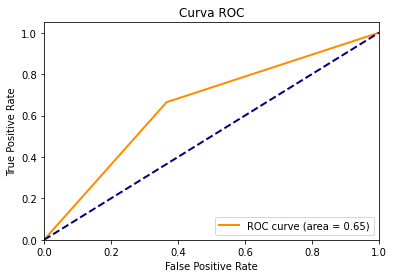

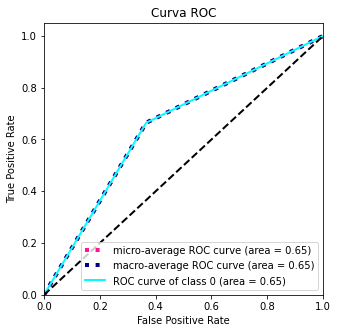

In [18]:
get_roc_curves(y_test,y_pred)

## K - folds (Cross Validation with XGB)

In [20]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
xgb_cv = xgb.cv(
    dtrain=data_dmatrix,
    params=xgb_params,
    nfold=10,
    num_boost_round=50,
    early_stopping_rounds=10,
    metrics="auc",
    as_pandas=True,
    seed=123
)

# Old way to calc cross validation with Scikit-learn...
# k_fold_val(clf, X, y, "Naive Bayes", splits = 10)

xgb_cv contains train and test auc metrics for each boosting round...

In [21]:
xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.690219,0.000081,0.689236,0.000560
1,0.691059,0.000086,0.690061,0.000632
2,0.691948,0.000110,0.690911,0.000626
3,0.692788,0.000221,0.691723,0.000708
4,0.693394,0.000167,0.692274,0.000768


## Test Predictions

In [23]:
df_test = pd.read_csv('./datasets/test_preprocessed.csv', usecols=X_columns)

In [28]:
pred = clf.predict(df_test[X_columns])

In [29]:
df_test['predictions'] = pred

In [82]:
df_test[df_test['predictions'] > 0]['predictions'].head(10)

622986     1
888226     1
890080     1
899633     1
1031403    1
1043864    1
1189236    1
1197108    1
1295847    1
1393628    1
Name: predictions, dtype: int64